# Thinkful Data Science Event:
## Improving Results-

In the previous workshop, we used data from a Portugese banking institution to determine whether or not customers would end up subscribing for a "Term Subscription". The results can be found [here](https://github.com/zxs107020/Thinkful/blob/master/03_predicting_subscriptions.ipynb).

Today, we will build upon that experiment to see if we cant improve the results of our algorithm. 

There are many different ways to try and build upon a model in data science. Two of the most popular methods are:

**1) Feature Selection**

**2) Principal Component Analysis**

These methods differ slightly in their methodology, but the end goal is the same in each case: reduce the amount of variance and correlation present between variables. 

Feature selection approaches this issue by trying to remove unnecessary variables based on their importance. 

On the other hand, principal component analysis attempts to reduce the variance by creating new variables that are a linear combination of the old features. 

Both of these methodologies can be extremely useful. Neither one always performs better than the other. Their effects on performance can vary between datasets depending on the number and types of features. 

### Getting Started

Please review the materials from previous workshops to refamiliarize yourself with our beginning steps for any data science project. 

Lets get started.

In [1]:
# Import the required libraries
import ml
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# Define the variables
wd = '/path/to/files'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
fn = 'bank-additional.zip'
path = 'staging/bank-additional'
header = 0
sep = ';'
target = 'bank-additional-full'

In [3]:
# Load the data
data = ml.dat_imp(wd, url, fn, path, header, sep, target)

In [4]:
# Select object columns
cols = data.columns[data.dtypes.eq('object')]

# Convert to categories
for col in cols:
    data[col] = data[col].astype('category')
    
# Initialize label encoder
le = LabelEncoder()

# Encode categories numerically
for col in cols:
    data[col] = le.fit_transform(data[col]) 

In [5]:
# Split the data into training, validation, and testing sets using `ml`
x_train, x_val, x_test, y_train, y_val, y_test = ml.separate(data, 'y', .3)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Recursive Feature Selection (RFE)

RFE is a popular and powerful method in data science for reducing the dimensionality of information within a project. The theory behind process is to selectively remove features and build models using the remaining attributes. At each step, the model accuracy is recorded. RFE is then able to work out the combination of attributes that have the highest prediction rate for the data, and it returns this list of features as its output.

In [6]:
# Initialize the model
clf = RandomForestClassifier()

In [7]:
# Instantiate
rfe = RFECV(estimator = clf, step = 1, cv = 5, scoring = 'accuracy')

In [8]:
# Model the data
rfecv = rfe.fit(x_train, y_train)

In [9]:
# Results
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 19


In [10]:
print('Best features :', x_train.columns[rfecv.support_])

Best features : Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')


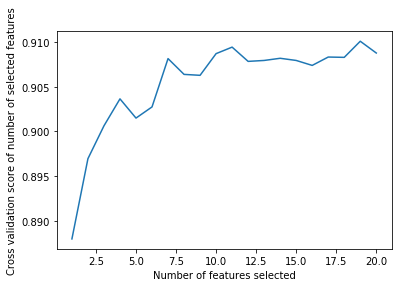

In [11]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Now we have two items to consider:

* The optimal number of features
* A list of which features are most important

Using this information, we can eliminate unnecessary variables from out data frame.

In [12]:
# Eliminate the unnecessary variables
keep = x_train.columns[rfecv.support_]
x_train = x_train[keep]
x_val = x_val[keep]
x_test = x_test[keep]

Now that everything is prepared, lets go ahead and rerun our logistic regression model from the last workshop.

In [13]:
# Test the performance

# Define the library and function
lib = 'from sklearn.linear_model import LogisticRegression'
func = 'LogisticRegression()'

# Perform the logistic regression using `ml`
preds, conf_mat, class_rep, acc = ml.machine_learning(lib, x_train, y_train, x_val, y_val, func)

In [14]:
# Check the results
print('Confusion Matrix for the Logistic Regression Model', '\n', conf_mat, '\n')

Confusion Matrix for the Logistic Regression Model 
 [[5394  127]
 [ 406  251]] 



In [15]:
print('Accuracy for the Logistic Regression Model', acc, '\n')

Accuracy for the Logistic Regression Model 0.9137261249595339 



In [16]:
print('Summary statistics for Logistic Regression Model', '\n', class_rep, '\n')

Summary statistics for Logistic Regression Model 
              precision    recall  f1-score   support

          0       0.93      0.98      0.95      5521
          1       0.66      0.38      0.49       657

avg / total       0.90      0.91      0.90      6178
 



Lets compare these results to our model from last time, which can be found [here](https://github.com/zxs107020/Thinkful/blob/master/03_predicting_subscriptions.ipynb).

First of all, our number of misclassified examples is 533. This is marginally better than the 543 from the unaltered dataset. 

The accuracy is the same though. 

Lets take a look at the ROC:

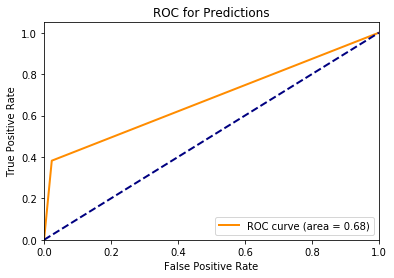

In [17]:
# Visualize the results with an ROC curve
ml.visualize(y_val, preds)

The AUC is also the same as it was before. 

So, in all- the RFE method did not offer much improvement over our base model. Although, we did have fewer misclassified examples: this can be extremely important in the real world. Especially when the object of experimentation is to enhance subscriptions. Misclassified examples represent lost earnings for the bank. 

### Principal Component Analysis (PCA)

PCA has a large number of varying applications in data science. It can be used to optimize algorithms and enhance the speed of performance. Furthermore, it has uses in terms of creating visualizations for data. 

In our situation, we are going to try and use this method to improve our model's accuracy. PCA could potentially achieve this goal because what it does is transform the original dataset into a new, linear combination of the existing features. The goal is to reduce the amount of total variance present in the data. This concern addresses issues that can confound our results such as multi-colinearity. These issues usually arise when there is a lot of correlation between variables. 

In any case, lets get to it.

In [18]:
# Resplit the data
x_train, x_val, x_test, y_train, y_val, y_test = ml.separate(data, 'y', .3)

In [19]:
# Initialize the model
pca = PCA(.95)

fit = pca.fit(x_train)

Before we go any further, lets see how many components the PCA ended up creating:

In [20]:
# Find the number of selected transformations
print('The PCA model chose', pca.n_components_, 'components', '\n')

The PCA model chose 2 components 



In [21]:
# Apply the transformations to the data
x_train = pca.transform(x_train)
x_val = pca.transform(x_val)

In [22]:
# Run the logistic regression again
preds, conf_mat, class_rep, acc = ml.machine_learning(lib, x_train, y_train, x_val, y_val, func)

In [23]:
# Check the results
print('Confusion Matrix for the Logistic Regression Model', '\n', conf_mat, '\n')

Confusion Matrix for the Logistic Regression Model 
 [[5399  122]
 [ 436  221]] 



In [24]:
print('Accuracy for the Logistic Regression Model', acc, '\n')

Accuracy for the Logistic Regression Model 0.9096795079313694 



In [25]:
print('Summary statistics for Logistic Regression Model', '\n', class_rep, '\n')

Summary statistics for Logistic Regression Model 
              precision    recall  f1-score   support

          0       0.93      0.98      0.95      5521
          1       0.64      0.34      0.44       657

avg / total       0.90      0.91      0.90      6178
 



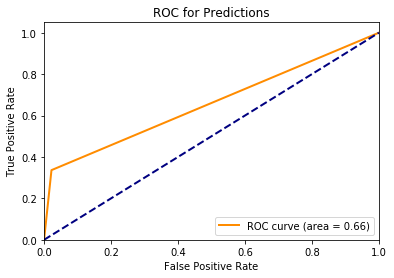

In [26]:
# Visualize the results with an ROC curve
ml.visualize(y_val, preds)

### Conclusion

Well, in this situation: the results of the PCA were a little disappointing. The model was not an improvement upon our initial attempt in terms of either accuracy or the AUC for the ROC. 

This can happen: it does not detract from the importance of at least attempting these types of methods. It just goes to show, there is no cookie-cutter method or sure-fire procedure for improving results. This is why the field is called data *science*. We must constantly develop and test new, different hypotheses in order to develop our skills and improve.

Thats all folks, until next time.